# Данные

Опишем доступные нам данные

**1.** olist_customers_datase.csv — **таблица с уникальными идентификаторами пользователей**   

| Field | Description |
| :--- | :--- |
| customer_id | позаказный идентификатор пользователя |
| customer_unique_id | уникальный идентификатор пользователя (аналог номера паспорта) |
| customer_zip_code_prefix | почтовый индекс пользователя |
| customer_city | город доставки пользователя |
| customer_state | штат доставки пользователя | 

**2.** olist_order_items_dataset.csv —  **товарные позиции, входящие в заказы**

| Field | Description |
| :--- | :--- |
| order_id | уникальный идентификатор заказа (номер чека) |
| order_item_id | идентификатор товара внутри одного заказа |
| product_id | ид товара (аналог штрихкода) |
| seller_id | ид производителя товара |
| shipping_limit_date | максимальная дата доставки продавцом для передачи заказа партнеру по логистике |
| price | цена за единицу товара |
| freight_value | вес товара |

**3.** olist_orders_dataset.csv —  **таблица заказов**  

| Field | Description |
| :--- | :--- |
| order_id | уникальный идентификатор заказа (номер чека) |
| customer_id | позаказный идентификатор пользователя |
| order_status | статус заказа |
| order_purchase_timestamp | время создания заказа |
| order_approved_at | время передачи заказа в логистическую службу |
| order_delivered_carrier_date | максимальная дата доставки продавцом для передачи заказа партнеру по логистике |
| order_delivered_customer_date | время доставки заказа |
| order_estimated_delivery_date | обещанная дата доставки  |  



**Уникальные статусы заказов** в таблице olist_orders_dataset:
* created —  создан
* approved —  подтверждён
* invoiced —  выставлен счёт
* processing —  в процессе сборки заказа
* shipped —  отгружен со склада
* delivered —  доставлен пользователю
* unavailable —  недоступен
* canceled —  отменён

In [1]:
%%html
<!-- Передвинем таблицы налево -->
<style>table {float:left}</style> 

# Импорт необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Вспомогательные функции для RFM-сегментации
from rfm_secondary_funcs import scorer, segmenter

# Библиотеки для извлечения данных
import requests
import urllib
import json



# Настройки по-умолчанию для визуализаций в данном проекте.

In [3]:
plot_params = {'figure.titlesize': 22,
               'axes.titlesize': 22,
               'axes.labelsize': 14,
               'axes.titlepad': 20,
               'legend.fontsize': 18,
               'legend.title_fontsize': 18                                   
              }

sns.set_theme(style="whitegrid", palette="RdYlBu_r", rc=plot_params)

# Извлечение данных

In [4]:
# Доступ на скачивание файла с Yandex disk через API
yandex_api = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

# Создаем список url для скачивания необходимых таблиц с данными
data_download_urls = []

# Ссылки на файлы лежащие на Yandex disk
olist_customers_datase_url    = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
olist_orders_dataset_url      = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
olist_order_items_dataset_url = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

disk_urls = [olist_customers_datase_url, olist_orders_dataset_url, olist_order_items_dataset_url]

In [5]:
# Заполняем список data_download_urls для скачивания необходимых таблиц с данными
for disk_url in disk_urls:
    # Итоговый url для скачивания файла
    url = yandex_api + urllib.parse.urlencode(dict(public_key=disk_url))        
    
    # Запрос и извлечение ссылки на скачивание
    r = requests.get(url)
    h = json.loads(r.text)['href']
    
    # Добавляем ссылку на скачивание в общий список
    data_download_urls.append(h)

In [6]:
# Нам заранее известны поля с данными, которые можно преобразовать в даты. Составим их список.
# В таблице заказов этих полей много, запишем их в список.
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
               'order_delivered_customer_date', 'order_estimated_delivery_date']


# Создаем датафреймы из полученных ссылок. Сразу парсим даты в удобный формат данных.
users    = pd.read_csv(data_download_urls[0], sep=',')
orders   = pd.read_csv(data_download_urls[1], sep=',', parse_dates=date_fields)
products = pd.read_csv(data_download_urls[2], sep=',', parse_dates=['shipping_limit_date'])

# Подготовка и очистка данных

### Для решения задачи проведем предварительное исследование данных и сформулируем, что должно считаться покупкой. 

##### Предварительный план.
Заказ успешен если:
- order_approved_at - не null. То есть оплата подтверждена  
и
- order_status - не unavailable(недоступен) и не canceled(отменён). То есть товар обеспечен, а покупка не отменена.

Объединим данные о клиентах и заказах

In [7]:
users_orders = users.merge(orders, on='customer_id')

Посмотрим на полученные данные.

In [8]:
print(f'Общее количество уникальных заказов: {users_orders.order_id.nunique()} шт.')
print(f'Общее количество уникальных клиентов: {users_orders.customer_unique_id.nunique()} человек\n')

print(f'Первая подтвержденная дата оплаты заказа: {users_orders.order_approved_at.min()}')
print(f'Последняя подтвержденная дата оплаты заказа: {users_orders.order_approved_at.max()}\n')

print('Распределение количества заказов по статусам:')
print(orders.order_status.value_counts())

Общее количество уникальных заказов: 99441 шт.
Общее количество уникальных клиентов: 96096 человек

Первая подтвержденная дата оплаты заказа: 2016-09-15 12:16:38
Последняя подтвержденная дата оплаты заказа: 2018-09-03 17:40:06

Распределение количества заказов по статусам:
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


Посмотрим на оплаченные, но не доставленные заказы в статусе **'canceled'**:

In [9]:
(users_orders[users_orders.order_delivered_customer_date.isnull() & ~users_orders.order_approved_at.isnull()]
 .query('order_status == "canceled"')).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 46 to 99178
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    478 non-null    object        
 1   customer_unique_id             478 non-null    object        
 2   customer_zip_code_prefix       478 non-null    int64         
 3   customer_city                  478 non-null    object        
 4   customer_state                 478 non-null    object        
 5   order_id                       478 non-null    object        
 6   order_status                   478 non-null    object        
 7   order_purchase_timestamp       478 non-null    datetime64[ns]
 8   order_approved_at              478 non-null    datetime64[ns]
 9   order_delivered_carrier_date   69 non-null     datetime64[ns]
 10  order_delivered_customer_date  0 non-null      datetime64[ns]
 11  order_estimated_

Всего таких заказов 478, из них 69 уже переданы курьеру.

Есть заказы отмененные на этапе подтверждения оплаты, передачи курьеру и уже после доставки:

In [10]:
users_orders.query('order_status == "canceled"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 46 to 99178
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    625 non-null    object        
 1   customer_unique_id             625 non-null    object        
 2   customer_zip_code_prefix       625 non-null    int64         
 3   customer_city                  625 non-null    object        
 4   customer_state                 625 non-null    object        
 5   order_id                       625 non-null    object        
 6   order_status                   625 non-null    object        
 7   order_purchase_timestamp       625 non-null    datetime64[ns]
 8   order_approved_at              484 non-null    datetime64[ns]
 9   order_delivered_carrier_date   75 non-null     datetime64[ns]
 10  order_delivered_customer_date  6 non-null      datetime64[ns]
 11  order_estimated_

Несмотря на данные выше исключим все отмененные заказы.  
Они однозначно не должны считаться покупками, так как деньги за них мы вернем.  
Создадим датафрейм с покупками, в котором исключим отмененные заказы.

In [11]:
purchases = users_orders.query('order_status != "canceled"')

Теперь рассмотрим заказы в статусе **'unavailable'**:

In [12]:
purchases.query('order_status == "unavailable"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 288 to 99105
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    609 non-null    object        
 1   customer_unique_id             609 non-null    object        
 2   customer_zip_code_prefix       609 non-null    int64         
 3   customer_city                  609 non-null    object        
 4   customer_state                 609 non-null    object        
 5   order_id                       609 non-null    object        
 6   order_status                   609 non-null    object        
 7   order_purchase_timestamp       609 non-null    datetime64[ns]
 8   order_approved_at              609 non-null    datetime64[ns]
 9   order_delivered_carrier_date   0 non-null      datetime64[ns]
 10  order_delivered_customer_date  0 non-null      datetime64[ns]
 11  order_estimated

Заказы в статусе недоступно не были отгружены курьеру и не были доставлены.  
Однако, по всем таким заказам была подтверждена оплата.  
Тем не менее, на данный момент такие заказы тоже нельзя считать покупками, так как товар не обеспечен.

In [13]:
purchases = purchases.query('order_status != "unavailable"')

Очевидно что только что созданные заказы (статус **'created'**) тоже не являются покупками.  
На всякий случай проверим уникальные даты принятия оплаты:

In [14]:
purchases.query('order_status == "created"').order_approved_at.unique()

array(['NaT'], dtype='datetime64[ns]')

Исключим эти заказы, так как не оплаченные позиции не могут считаться покупками.

In [15]:
purchases = purchases.query('order_status != "created"')

Рассмотрим данные после первого этапа подготовки.  

In [16]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98202 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    98202 non-null  object        
 1   customer_unique_id             98202 non-null  object        
 2   customer_zip_code_prefix       98202 non-null  int64         
 3   customer_city                  98202 non-null  object        
 4   customer_state                 98202 non-null  object        
 5   order_id                       98202 non-null  object        
 6   order_status                   98202 non-null  object        
 7   order_purchase_timestamp       98202 non-null  datetime64[ns]
 8   order_approved_at              98188 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97583 non-null  datetime64[ns]
 10  order_delivered_customer_date  96470 non-null  datetime64[ns]
 11  order_estimated

У нас все еще остались заказы для которых нет даты подтверждения оплаты или предачи курьеру или доставки клиенту.  
Оставим те заказы где есть дата подтверждения оплаты.

In [17]:
purchases = purchases[~purchases.order_approved_at.isnull()]

Полученный датафрейм **purchases** c заказами, **будем считать покупками**.  
Даже не смотря на то что товары могут быть не переданы курьеру и/или не доставлены клиенту.  
Оплату мы получили, товар обепечен на складе, значит на данный момент - это **покупки**.

In [18]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98188 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    98188 non-null  object        
 1   customer_unique_id             98188 non-null  object        
 2   customer_zip_code_prefix       98188 non-null  int64         
 3   customer_city                  98188 non-null  object        
 4   customer_state                 98188 non-null  object        
 5   order_id                       98188 non-null  object        
 6   order_status                   98188 non-null  object        
 7   order_purchase_timestamp       98188 non-null  datetime64[ns]
 8   order_approved_at              98188 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 10  order_delivered_customer_date  96456 non-null  datetime64[ns]
 11  order_estimated

### Подготовка данных о связке заказ-товар

Посмотрим на заказы где нам не известны даты доставки при статусе доставлено.

In [19]:
orders[orders.order_delivered_customer_date.isnull()].query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Видим расхождение в полях статуса заказа и даты доставки. При этом все заказы кроме одного переданы в доставку.

Примем за условие, что **'order_status'** приоритетнее **'order_delivered_customer_date'**.  
То есть, если стаус - доставлено, значит на самом деле так и есть, просто кто-то забыл проставить дату.  
Учитывая что строк с несоответствиями всего 8 - это разумное допущение.  
Мы могли бы просто отбросить эти заказы, так как их мало на общем фоне, однако так не интересно.  
Заполним недостающие значения в полях дат доставки и передачи курьеру

Объединим данные о продуктах (**products**) и заказах (**orders**) для дальнейшей обработки.

In [20]:
orders_products = orders.merge(products, on='order_id', how='right')

Для строчки co статусом доставлено, но не переданную курьеру и без даты доставки, вместо даты передачи установим макс дату из продуктовой таблицы.

In [21]:
orders_products.loc[
    (orders_products.order_delivered_customer_date.isnull()) &     
    (orders_products.order_delivered_carrier_date.isnull()) &
    (orders_products.order_status == 'delivered'), 
    'order_delivered_carrier_date'] = orders_products.shipping_limit_date

Посчитаем медианное время доставки товаров от момента передачи курьеру до момента доставки клиенту.

In [22]:
mean_delivery_time = (orders_products['order_delivered_customer_date'] - orders_products['order_delivered_carrier_date']).mean()

Заполним недостающие даты доставки клиенту при статусе доставлено.  
Для этого прибавим среднее время доставки к дате передачи курьеру.

In [23]:
orders_products.loc[
    (orders_products.order_delivered_customer_date.isnull()) &        
    (orders_products.order_status == 'delivered'), 
    'order_delivered_customer_date'] = orders_products.order_delivered_carrier_date + mean_delivery_time

По итогам заполнения получим датафрейм **orders_products**, где у всех заказов в статусе доставлено есть дата доставки

In [24]:
orders_products.query('order_status == "delivered"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110196 non-null  datetime64[ns]
 6   order_delivered_customer_date  110197 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   order_item_id                  110197 non-null  int64         
 9   product_id                     110197 non-null  object        
 10  seller_id                      110197 non-null  object        
 11  

Заполним оставшееся значение даты передачи курьеру по макс дате из продуктовой таблицы.

In [25]:
orders_products.loc[(orders_products['order_status'] == "delivered") & 
                    (orders_products.order_delivered_carrier_date.isnull()),
                    'order_delivered_carrier_date'] = orders_products.shipping_limit_date

Таким образом, все доставленные заказы имеют даты доставки и передачи курьеру.  
По некоторым мы все еще ждем оплату, но это нормально =)

In [26]:
orders_products.query('order_status == "delivered"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110197 non-null  datetime64[ns]
 6   order_delivered_customer_date  110197 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110197 non-null  datetime64[ns]
 8   order_item_id                  110197 non-null  int64         
 9   product_id                     110197 non-null  object        
 10  seller_id                      110197 non-null  object        
 11  

На этом закончим подготовку данных и перейдем непосредственно к поставленным задачам.

### 1 
Сколько **пользователей**, cовершивших покупку **только один раз**?

Сгруппируем покупки по уникальным пользователям, и посчитаем кол-во их покупок

In [27]:
users_purchases = (purchases
                   .groupby('customer_unique_id', as_index=False)
                   .agg(purchases_amount=('customer_id', 'count'))
                  ).purchases_amount.value_counts().rename_axis('purchases_count').reset_index(name='purchases_amount')

In [28]:
users_purchases.head()

,purchases_count,purchases_amount
0,1,92087
1,2,2650
2,3,188
3,4,29
4,5,9


Визуализируем полученные данные.

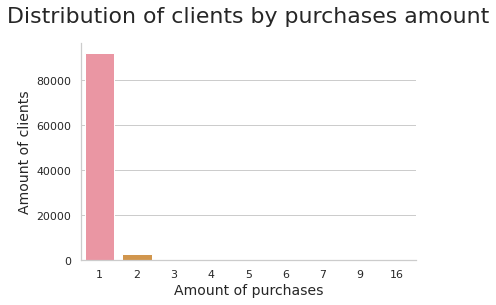

In [29]:
sns.barplot(data=users_purchases, x='purchases_count', y='purchases_amount')
            
plt.xlabel('Amount of purchases')
plt.ylabel('Amount of clients')
plt.title('Distribution of clients by purchases amount')

sns.despine()
plt.show()

Подавляющее большинство клиентов совершило не более одной покупки.  
Достаточно большое количество клиентов совершило не более двух покупок.  
Представленный график - не наглядный, так как распределение слишком сильно смещено.  
Для анализа тренда возьмем логарифм от количества клиентов.

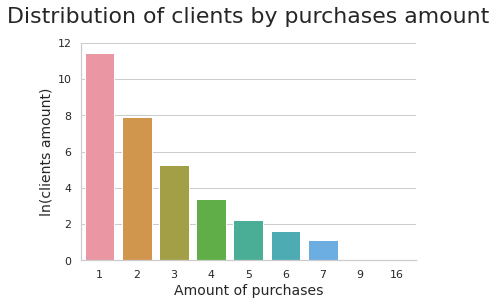

In [30]:
users_purchases['purchases_amount_ln'] = np.log(users_purchases['purchases_amount'])

sns.barplot(data=users_purchases, x='purchases_count', y='purchases_amount_ln')            

plt.xlabel('Amount of purchases')
plt.ylabel('ln(clients amount)')
plt.title('Distribution of clients by purchases amount')

sns.despine()
plt.show()

В целом распределение клиентов по количеству покупок выглядит разумным.  
Посмотрим сколько клиентов совершили только одну покупку.

In [31]:
one_purchase_users = users_purchases.loc[users_purchases.purchases_count == 1, 'purchases_amount'].values[0]

print(f'{one_purchase_users} пользователей совершили только одну покупку.')

92087 пользователей совершили только одну покупку.


### 2  
Сколько заказов **в месяц в среднем** не доставляется по разным причинам?

Используем подготовленные заранее данные, исключив из них заказы со статусом **'delivered'**.  
Как было условлено, все заказы со статусом доставлено, считаем истинно доставленными.

In [32]:
undelivered_products = orders_products.query('order_status != "delivered"')

Посмотрим на полученные данные.

In [33]:
undelivered_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 79 to 112421
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       2453 non-null   object        
 1   customer_id                    2453 non-null   object        
 2   order_status                   2453 non-null   object        
 3   order_purchase_timestamp       2453 non-null   datetime64[ns]
 4   order_approved_at              2453 non-null   datetime64[ns]
 5   order_delivered_carrier_date   1261 non-null   datetime64[ns]
 6   order_delivered_customer_date  7 non-null      datetime64[ns]
 7   order_estimated_delivery_date  2453 non-null   datetime64[ns]
 8   order_item_id                  2453 non-null   int64         
 9   product_id                     2453 non-null   object        
 10  seller_id                      2453 non-null   object        
 11  shipping_limit

Видим, что есть семь заказов, у которых есть дата доставки клиенту, несмотря на то что мы исключили строки со статусом **'delivered'**.   
Проверим их статус.

In [34]:
undelivered_products[~undelivered_products.order_delivered_customer_date.isnull()].order_status.unique()

array(['canceled'], dtype=object)

Таким образом у нас есть заказы, которые были доставлены, но после этого отменены.  
Отбросим эти значения, так как отмена заказа произошла уже после доставки, а значит формально они были доставлены.

In [35]:
undelivered_products = undelivered_products[undelivered_products.order_delivered_customer_date.isnull()]

Теперь посмотрим на статусы заказов у которых нет даты передачи курьеру

In [36]:
undelivered_products[undelivered_products.order_delivered_carrier_date.isnull()].order_status.unique()

array(['canceled', 'invoiced', 'processing', 'approved', 'unavailable'],
      dtype=object)

В целом полученные статусы соответствуют логике процесса продажи. Ничего корректировать не надо.  
Полученный выше список статусов заказов - это собственно и есть причины, по которым заказ не доставлен.

Проанализируем причины "не доставки" заказов, сгруппируем данные по обещанной дате доставки.  
Для этого предварительно преобразуем дату в вид YYYY-MM для сортировки по месяцам.

In [37]:
undelivered_products.loc[:,'order_estimated_delivery_date'] \
= pd.DatetimeIndex(undelivered_products['order_estimated_delivery_date']).to_period('M')

undelivered_products_status = (undelivered_products
                               .groupby(['order_estimated_delivery_date', 'order_status'], as_index=False)
                               .agg(undelivered_amount=('order_id', 'count'))
                              )

Таким образом мы получили данные о количестве заказов, которые не были доставлены, с разбивкой по статусу и месяцу.

In [38]:
undelivered_products_status.head()

,order_estimated_delivery_date,order_status,undelivered_amount
0,2016-10,canceled,2
1,2016-10,shipped,2
2,2016-11,canceled,1
3,2016-11,invoiced,10
4,2016-11,shipped,1


Посчитаем среднее количество недоставленных заказов по разным причинам.

In [39]:
mean_undelivered = (undelivered_products_status
                    .groupby('order_status', as_index=False) 
                    .agg(mean_undelivered_orders=('undelivered_amount', 'mean'))
                    .sort_values(by='mean_undelivered_orders', ascending=False)
                    .round(3)
                   )
mean_undelivered.head(5)

,order_status,mean_undelivered_orders
4,shipped,51.522
1,canceled,24.318
3,processing,18.789
2,invoiced,17.095
5,unavailable,3.500


Визуализируем данные.

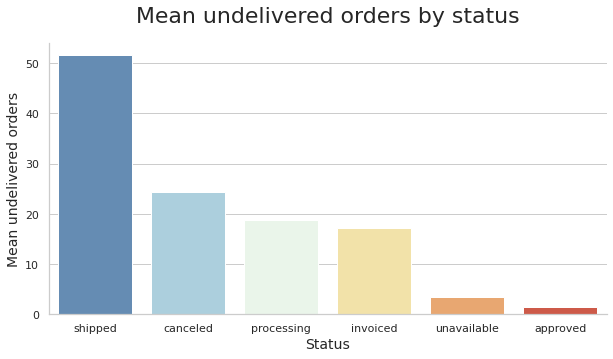

In [40]:
plt.figure(figsize=(10, 5))

sns.barplot(data=mean_undelivered, x='order_status', y='mean_undelivered_orders')

plt.xlabel('Status')
plt.ylabel('Mean undelivered orders')
plt.title('Mean undelivered orders by status')

sns.despine()
plt.show()

Также посмотрим на динамику количества недоставленных заказов по месяцам

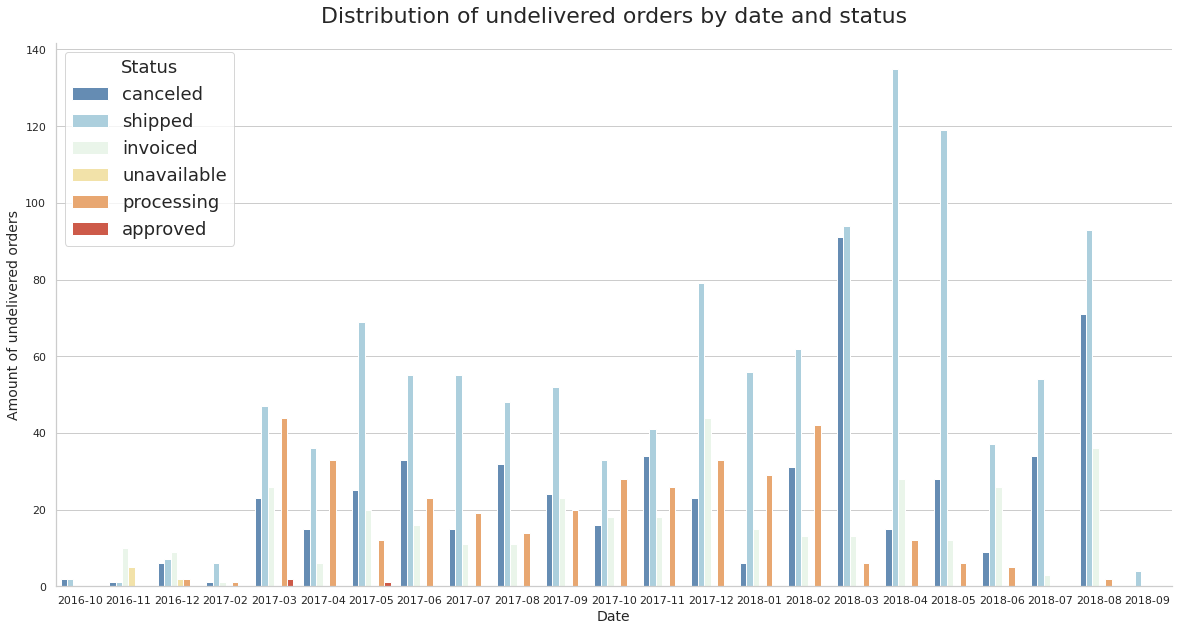

In [41]:
plt.figure(figsize=(20, 10))

sns.barplot(data=undelivered_products_status, 
            x='order_estimated_delivery_date',
            y='undelivered_amount',
            hue='order_status'
           )

plt.xlabel('Date')
plt.ylabel('Amount of undelivered orders')
plt.title('Distribution of undelivered orders by date and status')
plt.legend(title='Status', loc='upper left')

sns.despine()
plt.show()

Видим, что большинство не доставленных заказов либо в пути, либо отменены. При этом очень малая часть на этапе предобработки.  
Таким образом, можно сделать вывод, что процессы обработки заказов выстроены хорошо, основные задержки в логистике.  
Также мы видим, что очень мало заказов в статусе недоступно - это говорит о правильной работе склада.  
Почти все предлагаемые товары реально доступны.

Посчитаем сколько мы в среднем не доставляем заказов в месяц по любой причине.

In [42]:
undelivered_amount_mean = mean_undelivered.mean_undelivered_orders.mean()

print(f'В среднем в месяц не доставляется {int(undelivered_amount_mean)} товаров.')

В среднем в месяц не доставляется 19 товаров.


### 3  
По **каждому товару** определим, в какой **день недели** товар чаще всего покупается.

Используем подготовленные заранее данные с покупками. Объединим эти данные с информацией о товарах.  
Датой покупки будем считать дату создания заказа **'order_purchase_timestamp'**.

In [43]:
products_purchases = purchases.merge(products, on='order_id')

На основе даты создания заказа, добавим поле с номером дня недели.  
По-умолчанию дни недели будут идти от 0 до 6, поэтому прибавим 1, чтобы выглядело привычнее.  
Также добавим поле с соответствующим названием дня недели.

In [44]:
products_purchases.loc[:,'purchase_weekday']      = products_purchases.order_purchase_timestamp.dt.dayofweek + 1
products_purchases.loc[:,'purchase_weekday_name'] = products_purchases.order_purchase_timestamp.dt.day_name()

Сгруппируем данные по уникальным продуктам и дням недели.  
Посчитаем сколько покупок продукта было в конкретный день недели.
Отсортируем по количеству покупок.    
Сбросим дупликаты по id продукта, кроме первого вхождения.  
  
Таким образом мы получим продукт день недли с макс количеством покупок и количество этих покупок.

In [45]:
weekday_product_purchases = (products_purchases
                             .groupby(['product_id', 'purchase_weekday', 'purchase_weekday_name'], as_index=False)
                             .agg(ordered_amount=('order_id', 'count'))
                             .sort_values(by='ordered_amount', ascending=False)
                             .drop_duplicates(subset='product_id', keep='first')
                            )

weekday_product_purchases.head(5)

,product_id,purchase_weekday,purchase_weekday_name,ordered_amount
15808,422879e10f46682990de24d770e7f83d,3,Wednesday,93
36304,99a4788cb24856965c36a24e339b6058,1,Monday,92
40818,aca2eb7d00ea1a7b8ebd4e68314663af,4,Thursday,89
20005,53b36df67ebb7c41585e8d54d6772e08,2,Tuesday,76
12933,368c6c730842d78016ad823897a372db,5,Friday,67


Посмотрим на количество продуктов.

In [46]:
print(f'{weekday_product_purchases.product_id.nunique()} уникальных продуктов в полученных данных')

32726 уникальных продуктов в полученных данных


Продуктов достаточно много, поэтому посмотрим на заказы по дням недели (общие и средние).

In [47]:
weekday_purchases = (products_purchases
                     .groupby(['product_id', 'purchase_weekday', 'purchase_weekday_name'], as_index=False)
                     .agg(ordered_amount=('order_item_id', 'count'))                                          
                     .groupby(['purchase_weekday', 'purchase_weekday_name'], as_index=False)
                     .agg(ordered_mean=('ordered_amount', 'mean'), ordered_total=('ordered_amount', 'sum'))
                    )

Визуализируем данные.

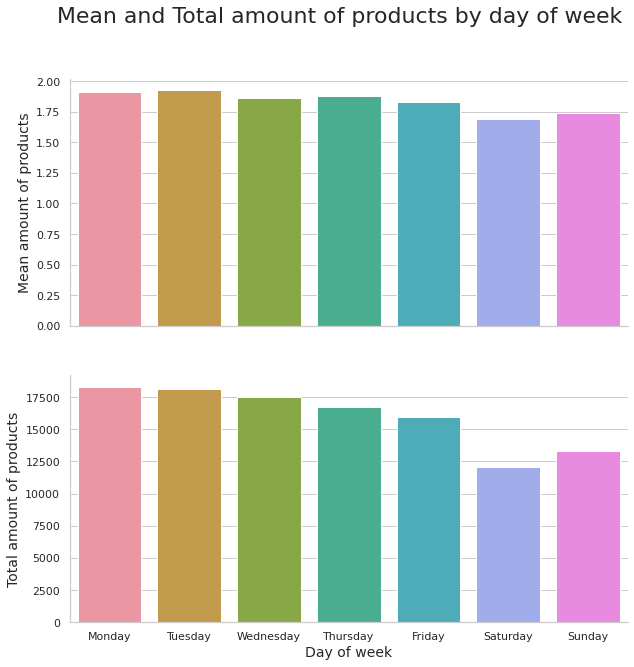

In [48]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

sns.barplot(data=weekday_purchases, x='purchase_weekday_name', y='ordered_mean', ax=ax1)          
sns.barplot(data=weekday_purchases, x='purchase_weekday_name', y='ordered_total', ax=ax2)

ax1.set_xlabel('')
ax1.set_ylabel('Mean amount of products')

ax2.set_xlabel('Day of week')
ax2.set_ylabel('Total amount of products')

plt.suptitle('Mean and Total amount of products by day of week')

sns.despine()
plt.show()

В среднем по дням недели у нас покупают 2 товара.  
Больше всего покупок приходится на начало недели, меньше всего на выходные.

### 4  
Сколько у каждого из **пользователей в среднем покупок в неделю** (по месяцам)?  

Используем подготовленные заранее данные с покупками.  
Датой покупки будем считать дату создания заказа **'order_purchase_timestamp'**.

Добавим столбцы с месяцем и неделей совершения покупки.

In [49]:
purchases['week']  = purchases.order_purchase_timestamp.dt.isocalendar().week
purchases['month'] = pd.DatetimeIndex(purchases['order_purchase_timestamp']).to_period('M')

Оставим только необходимые столбцы для рассчета среднего кол-ва покупок.

In [50]:
purchases_by_week = purchases[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'week', 'month']]

Для проверки посмотрим сколько у нас уникальных клиентов, совершивших покупки, а также сколько всего было покупок.

In [51]:
unique_customers = purchases_by_week.customer_unique_id.nunique()
orders_amount    = purchases_by_week.shape[0]

print(f'{unique_customers} клиентов совершили {orders_amount} покупок.')

94973 клиентов совершили 98188 покупок.


Видим, что есть покупатели, которые совершали более одной покупки, значит дальнейшее исследование имеет смысл.

Сгруппируем данные по пользователям и месяцу покупки.  
Посчитаем сколько каждый пользователь совершил покупок в конкретный месяц. 

In [52]:
mean_purchases_by_week = (purchases_by_week
                          .groupby(['customer_unique_id', 'month'], as_index=False)
                          .agg(orders_amount=('order_id', 'count'))                          
                         )

Для каждого клиента, поделим количество заказов в месяц на количество недель в этом месяце.

In [53]:
weeks = (mean_purchases_by_week.month.dt.daysinmonth / 7) # количество недель в месяце
mean_purchases_by_week['mean_orders_weekly'] = (mean_purchases_by_week.orders_amount / weeks).round(3)

Проверим, что количество уникальных клиентов не изменилось.

In [54]:
if mean_purchases_by_week.customer_unique_id.nunique() == unique_customers:
    print('Мы не потеряли клиентов.')
else:
    print('Что-то не так. Мы потеряли клиентов!!!')  

Мы не потеряли клиентов.


Таким образом можно посмотреть сколько каждый клиент заказывал в неделю в среднем по месяцам:

In [55]:
mean_purchases_by_week[['customer_unique_id', 'mean_orders_weekly']].head()

,customer_unique_id,mean_orders_weekly
0,0000366f3b9a7992bf8c76cfdf3221e2,0.226
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.226
2,0000f46a3911fa3c0805444483337064,0.226
3,0000f6ccb0745a6a4b88665a16c9f078,0.226
4,0004aac84e0df4da2b147fca70cf8255,0.233


Посмотрим на рапределение.  
Визуализация абсолютного распределения не наглядная, так как распределение сильно смещено.  
Для анализа тренда, добавим логарифм количества клиентов.

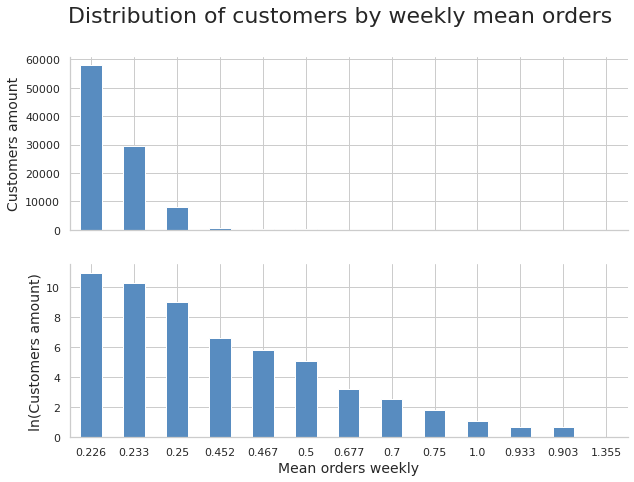

In [56]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))

mean_purchases_by_week.mean_orders_weekly.value_counts().plot.bar(rot=0, ax=ax1)
np.log(mean_purchases_by_week.mean_orders_weekly.value_counts()).plot.bar(rot=0, ax=ax2)

plt.xlabel('Mean orders weekly')
ax1.set_ylabel('Customers amount')
ax2.set_ylabel('ln(Customers amount)')

plt.suptitle('Distribution of customers by weekly mean orders')

sns.despine()
plt.show()

Видим, что большинство пользователей совершает в среднем одну покупку за неделю в месяц.  
Это согласуется с полученными ранее данными, так как мы знаем что большинство клиентов совершило только одну покупку.  
*В месяце примерно 4..4.3 недели => (1 покупка) / (4..4.3 недели) ~= 0.23-0.25*

Тем не менее есть и заметная часть тех кто совершает в среднем две покупки в неделю за месяц.  
*Mean orders == 0.45*  
И даже те кто совершает более 2 покупок, но их совсем мало на общем фоне

### 5  
Используя pandas, проведем **когортный анализ пользователей**.  
В период **с января по декабрь** выявим когорту с **самым высоким retention на 3й месяц**.  


Используем подготовленные заранее данные с покупками.  
Датой первой покупки(**Month 0**) будем считать дату создания заказа **'order_purchase_timestamp'**.

Отберем необходимые для анализа столбцы.

In [57]:
cohorts = purchases[['month', 'customer_unique_id', 'order_id', ]]

Посмотрим на количество уникальных клиентов.

In [58]:
print(f'В наших данных {cohorts.customer_unique_id.nunique()} уникальных клиентов.')

В наших данных 94973 уникальных клиентов.


Посмотрим на доступный нам диапазон дат в данных.  
Конкретно на месяцы, для которых у нас есть информация с января по декабрь

In [59]:
sorted(cohorts.month.unique())

[Period('2016-09', 'M'),
 Period('2016-10', 'M'),
 Period('2016-12', 'M'),
 Period('2017-01', 'M'),
 Period('2017-02', 'M'),
 Period('2017-03', 'M'),
 Period('2017-04', 'M'),
 Period('2017-05', 'M'),
 Period('2017-06', 'M'),
 Period('2017-07', 'M'),
 Period('2017-08', 'M'),
 Period('2017-09', 'M'),
 Period('2017-10', 'M'),
 Period('2017-11', 'M'),
 Period('2017-12', 'M'),
 Period('2018-01', 'M'),
 Period('2018-02', 'M'),
 Period('2018-03', 'M'),
 Period('2018-04', 'M'),
 Period('2018-05', 'M'),
 Period('2018-06', 'M'),
 Period('2018-07', 'M'),
 Period('2018-08', 'M'),
 Period('2018-09', 'M')]

Видим что информация с января по декабрь есть только для 2017 года.  
Отберем только эти данные.

In [60]:
cohorts = cohorts.query('(month >= "2017-01") & (month <= "2017-12")')

Для каждого клиента получим месяц, в который была совершена первая покупка.

In [61]:
month_0_customers = cohorts.groupby('customer_unique_id', as_index=False).agg(month_0 = ('month', 'min'))

In [103]:
month_0_customers

,customer_unique_id,month_0
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07
...,...,...
43012,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12
43013,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
43014,fffea47cd6d3cc0a88bd621562a9d061,2017-12
43015,ffff371b4d645b6ecea244b27531430a,2017-02


Дополним данные месяцем первой покупки для каждого клиента по каждому заказу.

In [62]:
cohorts = cohorts.merge(month_0_customers, how='left')

Проверим, что у нас есть клиенты, которые совершали покупки в месяц, отличный от первого месяца покупки.

In [63]:
cohorts.loc[cohorts['month'] != cohorts['month_0']].customer_unique_id.nunique()

574

Видим что есть клиенты, которые совершали покупки несколько раз в разные месяцы

Для каждой покупки посчитаем период в месяцах от даты первой покупки

In [64]:
cohorts['cohort_period'] = cohorts.month.view(dtype='int64') - cohorts.month_0.view(dtype='int64')

Посчитаем уникальных клиентов в каждый из месяцев в каждый из периодов

In [65]:
cohort_df = (cohorts
             .groupby(['cohort_period','month_0'], as_index=False)
             .agg(uniq_customers=('customer_unique_id', 'nunique'))
             .reset_index()             
             .rename(columns={'month_0': 'cohort'})
            ).pivot(index='cohort', columns='cohort_period', values='uniq_customers')

Посчитаем **retention**.

In [66]:
retention = cohort_df.divide(cohort_df.iloc[:,0], axis = 0).round(5)

Добавим стилизацию данных, для удобства восприятия.  
Переведем значение **retention** в проценты. "Закрасим" NaN значения.

In [67]:
(retention
 .style
 .set_caption('Customers retention by cohort') 
 .background_gradient(cmap='RdYlBu_r')
 .highlight_null('white')
 .format("{:.3%}", na_rep="")
)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.000%,0.399%,0.266%,0.133%,0.399%,0.133%,0.399%,0.133%,0.133%,,0.399%,0.133%
2017-02,100.000%,0.238%,0.298%,0.119%,0.417%,0.119%,0.238%,0.179%,0.060%,0.179%,0.119%,
2017-03,100.000%,0.506%,0.350%,0.389%,0.350%,0.156%,0.156%,0.311%,0.350%,0.078%,,
2017-04,100.000%,0.602%,0.215%,0.172%,0.301%,0.258%,0.344%,0.301%,0.301%,,,
2017-05,100.000%,0.480%,0.480%,0.395%,0.311%,0.339%,0.424%,0.141%,,,,
2017-06,100.000%,0.451%,0.355%,0.387%,0.258%,0.387%,0.355%,,,,,
2017-07,100.000%,0.523%,0.340%,0.235%,0.288%,0.209%,,,,,,
2017-08,100.000%,0.678%,0.339%,0.266%,0.363%,,,,,,,
2017-09,100.000%,0.687%,0.540%,0.294%,,,,,,,,


Определим когорту с максимальным значением retention на 3 месяц.

In [68]:
cohort_period = 3

print('Когорта с максимальным значением retention на 3 месяц:', retention.loc[:, cohort_period].idxmax())

Когорта с максимальным значением retention на 3 месяц: 2017-05


### 6  
Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.  
В кластеризации выберем следующие метрики:  
* R - время от последней покупки пользователя до текущей даты,  
* F - суммарное количество покупок у пользователя за всё время,  
* M - сумма покупок за всё время.  

Поскольку один из параметров RFM подхода, метрика(Monetary), подрузамевает покупки, воспользуемся подготовленными заранее данными о покупках **purchases**.

Для расчета необходимых параметров добавим к данным о покупками данные о товарах.

In [69]:
products_purchases = purchases.merge(orders_products, on='order_id', how='left')

В полученной таблице много лишних полей, оставим только необходимые для построения RFM.

In [70]:
products_purchases = products_purchases[['order_id', 'order_purchase_timestamp_x', 'customer_id_x', 'customer_unique_id',
                                         'order_status_y', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
                                         'price', 'freight_value', 'order_approved_at_x']]

Переименуем поля, которые были продублированы в процессе объединения таблиц. 

In [71]:
products_purchases.rename(columns={'order_purchase_timestamp_x': 'order_purchase_timestamp',
                                   'customer_id_x': 'customer_id',
                                   'order_status_y': 'order_status', 
                                   'order_approved_at_x': 'order_approved_at'},
                          inplace=True)

Посмотрим на дату первого и последнего оформленного заказа.

In [72]:
oldest_order = products_purchases.order_purchase_timestamp.min()
newest_order = products_purchases.order_purchase_timestamp.max()

print(f' Первый заказ: {oldest_order}.\n Последний заказ: {newest_order}')

 Первый заказ: 2016-09-04 21:15:19.
 Последний заказ: 2018-09-03 09:06:57


Типовой временной период для RFM-сегментации - 1 год.  
Поскольку в наших данных полный год - только 2017, возьмем его для анализа.

In [73]:
products_purchases = products_purchases.query('(order_purchase_timestamp >= "2017-01") &\
                                               (order_purchase_timestamp < "2018-01")')

In [74]:
oldest_order = products_purchases.order_purchase_timestamp.min().date()
newest_order = products_purchases.order_purchase_timestamp.max().date()

print(f'Анализируемый период: от {oldest_order} до {newest_order}.')

Анализируемый период: от 2017-01-05 до 2017-12-31.


2017 год - это давний период времени, поэтому, для дальнейшего рассчета, условимся что сейчас 10 января 2018 года.  
Мы вернулись с праздников и решили проанализировать прошлый год.  
Поэтому зададим "сегодня" как дату последнего заказа + 10 дней.

In [75]:
today = products_purchases.order_purchase_timestamp.max() + pd.Timedelta(10, "d")

Добавим к данным колонку с количеством дней от последнего заказа.

In [76]:
products_purchases['days_since_order'] = (today - products_purchases['order_approved_at']).dt.days

Посмотрим на полученные данные.

In [77]:
products_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50602 entries, 0 to 112088
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  50602 non-null  object        
 1   order_purchase_timestamp  50602 non-null  datetime64[ns]
 2   customer_id               50602 non-null  object        
 3   customer_unique_id        50602 non-null  object        
 4   order_status              50602 non-null  object        
 5   order_item_id             50602 non-null  float64       
 6   product_id                50602 non-null  object        
 7   seller_id                 50602 non-null  object        
 8   shipping_limit_date       50602 non-null  datetime64[ns]
 9   price                     50602 non-null  float64       
 10  freight_value             50602 non-null  float64       
 11  order_approved_at         50602 non-null  datetime64[ns]
 12  days_since_order 

In [78]:
products_purchases.head(5)

,order_id,order_purchase_timestamp,customer_id,customer_unique_id,order_status,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at,days_since_order
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,delivered,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05-16 15:22:12,239
5,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,delivered,1.0,0be701e03657109a8a4d5168122777fb,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,259.90,22.31,2017-09-14 18:25:11,118
7,1093c8304c7a003280dd34598194913d,2017-11-16 19:29:02,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,delivered,1.0,124f74f703e88efe001a10bfa718b6ff,2a7dc43cecabf23403078e2188437d1d,2017-11-22 19:55:41,19.90,16.11,2017-11-16 19:55:41,55
10,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 17:23:20,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,delivered,1.0,6b874ff4c71d18e91079b40396bf176a,b6e1504972665f739dec4facb9943775,2017-12-01 18:01:20,25.30,15.10,2017-11-27 18:01:20,44
12,83d8f70418eefd96f37b483dff430305,2017-09-09 09:54:57,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,delivered,1.0,3fc00af0f0a8d4ac2933d3900416c977,7a241947449cc45dbfda4f9d0798d9d0,2017-09-14 10:10:17,99.00,18.31,2017-09-09 10:10:17,123


In [79]:
uniq_customers = products_purchases.customer_unique_id.nunique()
uniq_orders    = products_purchases.order_id.nunique()

print(f'{uniq_customers} уникальных клиентов оформили {uniq_orders} уникальных заказов.')

43017 уникальных клиентов оформили 44361 уникальных заказов.


Построение RFM-сегментации начнем с расчета метрик **Recency** и **Frequency**.

Для реализации подхода RFM нам нужно получить по одной строке на каждого клиента за период в один год (365 дней).  
Для этого сгруппируем данные по клиентам.  
**Recency**   - возьмем минимальное значение поля с количеством дней от последнего заказа для каждого клиента.  
**Frequency** - посчитаем количество заказов за рассчетный период.


In [80]:
rfm = (products_purchases
       .groupby('customer_unique_id', as_index=False)
       .agg(Recency=('days_since_order', 'min'), Frequency=('order_id', 'count'))
      )

Теперь к полученным данным надо добавить метрику Monetary для каждого уникального клиента.  
Несмотря на то, что в описании данных **'price'** - это цена за единицу товара, у нас нет абсолютно никаких данных о количестве товара в заказе.  
Поэтому будем считать что на самом деле это полная стомость позиции в заказе.

In [81]:
customers_monetary = products_purchases.groupby('customer_unique_id', as_index=False).agg(Monetary=('price', 'sum'))

Дополним наши данные для RFM-сегментации и посмотрим на полученные метрики.

In [82]:
rfm = rfm.merge(customers_monetary, on='customer_unique_id')
rfm.describe()

,Recency,Frequency,Monetary
count,43017.000000,43017.000000,43017.000000
mean,146.400353,1.176326,141.962988
std,95.550014,0.600461,223.837474
min,6.000000,1.000000,2.290000
25%,56.000000,1.000000,47.990000
50%,132.000000,1.000000,89.000000
75%,222.000000,1.000000,155.000000
max,370.000000,21.000000,13440.000000


In [83]:
rfm.head(5)

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,306,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,90,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,57,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,311,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,176,1,13.90


Заведем переменную **metrics** для дальнейших визуализаций. Эта переменная отражает количество исследуемых метрик.

In [84]:
metrics = 3

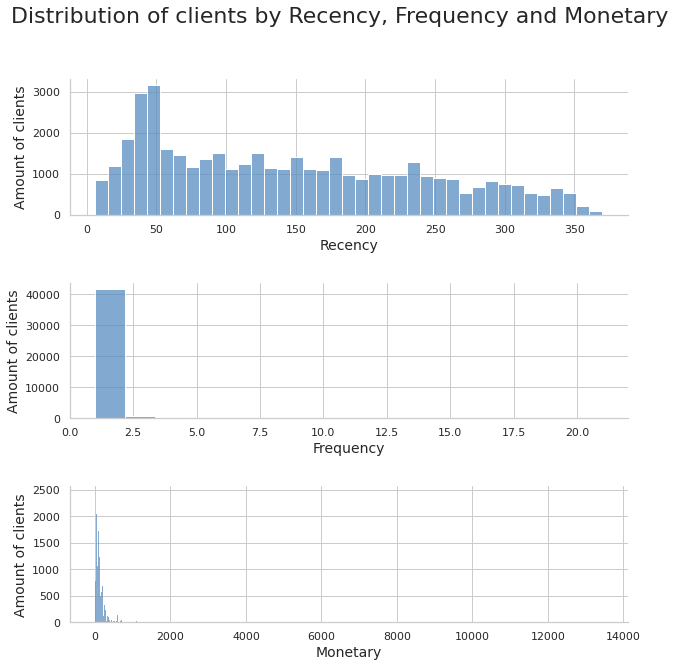

In [85]:
f, axes = plt.subplots(metrics, 1, figsize=(10,10))

for i in range(metrics):   
    ax     = axes[i]
    column = i + 1
    
    sns.histplot(data=rfm[rfm.columns[column]], ax=ax)
    
    ax.set_xlabel(rfm.columns[i+1])
    ax.set_ylabel('Amount of clients') 

plt.suptitle('Distribution of clients by Recency, Frequency and Monetary')
plt.subplots_adjust(hspace=0.5)
sns.despine()
plt.show()

Только **Recency** имеет более менее равномерное распределение. **Frequency** и **Monetary** сильно смещены влево.  
Деление клиентов на сегменты начнем с деления на квантили.  
Теоретически такой подход позволит нам применять алгоритм для любых новых данных.

In [86]:
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quantiles

{'Recency': {0.2: 47.0, 0.4: 100.0, 0.6: 165.0, 0.8: 241.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 68.9, 0.6: 108.57599999999991, 0.8: 179.96}}

Однако мы видим, что квантили для **Frequency** не годятся.

Помотрим на распределение этой метрики чуть подробнее.

In [87]:
rfm.Frequency.value_counts().head(7)

1    37722
2     4014
3      753
4      309
5      104
6       75
7       12
Name: Frequency, dtype: int64

Исходя из данных выше, сегментация метрики **Frequency** видится разумной на группы по количеству купленных товаров 1, 2, 3, 4, 5+

In [88]:
q = dict()
for i in range(1,6):
    q[i/5] = float(i)
    
quantiles['Frequency'] = q
quantiles

{'Recency': {0.2: 47.0, 0.4: 100.0, 0.6: 165.0, 0.8: 241.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 4.0, 1.0: 5.0},
 'Monetary': {0.2: 39.9, 0.4: 68.9, 0.6: 108.57599999999991, 0.8: 179.96}}

Таким образом наши сегменты выглядят так (5 - наилучшее, 1 - наихудшее):  

1. **Recency**:  
    1) 241 день и больше  
    2) 165-240 дней  
    3) 101-164 дней  
    4) 47-100 дней  
    5) 0-46 дней

2. **Frequency**:  
    1) 1 покупка  
    2) 2 покупки  
    3) 3 покупки  
    4) 4 покупки  
    5) 5 и более покупок

3. **Monetary**:   
    1) Сумма покупок 0-39.9   
    2) Сумма покупок 40-68.9  
    3) Сумма покупок 69-108.6  
    4) Сумма покупок 109-180  
    5) Сумма покупок 180 и более

Важно отметить, что только частота задана вручную и будет оцениваться, независимо от датасета.  
Оставшиеся два параметра рассчитываются исходя из предоствленных данных.  
Поэтому описание выше для этих двух параметров соответствует только данному датасету. Они будут адаптированы при изменении данных.

Воспользуемся подготовленной вспомогательной функцией для расчета оценки по метрикам и внесения ее в наши данные

In [89]:
rfm['r_score'] = rfm['Recency'].apply(lambda x: scorer(x, 'Recency', quantiles))
rfm['f_score'] = rfm['Frequency'].apply(lambda x: scorer(x, 'Frequency', quantiles))
rfm['m_score'] = rfm['Monetary'].apply(lambda x: scorer(x, 'Monetary', quantiles))

Посчитаем общую RFM-оценку каждого клиента.

In [90]:
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

Посмотрим на полученные данные и убедимся, что мы получили то, что ожидали.

In [91]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score
0,0000f46a3911fa3c0805444483337064,306,1,69.00,1,1,3,113
1,0000f6ccb0745a6a4b88665a16c9f078,90,1,25.99,4,1,1,411
2,0004aac84e0df4da2b147fca70cf8255,57,1,180.00,4,1,5,415
3,0005e1862207bf6ccc02e4228effd9a0,311,1,135.00,1,1,4,114
4,0006fdc98a402fceb4eb0ee528f6a8d4,176,1,13.90,2,1,1,211


Посмотрим на количество уникальных оценок в наших данных.

In [92]:
print(f'Количество уникальных RFM-оценок: {rfm.rfm_score.nunique()}')

Количество уникальных RFM-оценок: 120


Это слишком большое число, поэтому нужно провести дополнительную сегментацию на более широкие группы.  

Сегменты с описанием, содержащим **'focus'** - это клиенты на которых стоит попробовать повлиять.  
Напомнить о нашем магазине, сделать таргетированную рекламу, предоставить персональное предложение (скидку)

| Split | Description | Type of customer |
| :--- | :--- | :--- |
| [1-3]1[1-5] | Недавняя покупка, 1 заказ | новый клиент | 
| [1-3][2-4][1-3] | Недавняя покупка, 2-4 заказа, малая сумма заказов | потенциальный лояльный клиент | 
| [1-3][2-4][4-5] | Недавняя покупка, 2-4 заказа, высокая сумма заказов | потенциальный топовый клиент |
| [1-3]5[1-3] | Недавняя покупка, 5+ заказов, малая сумма заказов | лояльный клиент |
| [1-3]5[4-5] | Недавняя покупка, 5+ заказов, высокая сумма заказов | топовый клиент |
| [4-5]1[1-5] | Давняя покупка, 1 заказ | скорее всего потерянный клиент |
| [4-5][2-4][1-5] | Давняя покупка, 2-4 заказа | цель для персональной акции 2 приоритета |
| [4-5]5[1-5] | Давняя покупка, 5+ заказов | цель для персональной акции 1 приоритета |


Создадим датафрейм согласно описанной выше сегментации.

In [93]:
split = ['[1-3]1[1-5]', '[1-3][2-4][1-3]', '[1-3][2-4][4-5]', '[1-3]5[1-3]',
         '[1-3]5[4-5]', '[4-5]1[1-5]', '[4-5][2-4][1-5]', '[4-5]5[1-5]']

desc = ['new customer', 'potentially loyal customer', 'potentially top customer', 'loyal customer', 
        'top customer', 'probably lost customer', 'second prior focus', 'first prior focus']

segments = pd.DataFrame({'rfm_split': split,'description': desc})

Дополним наши данные rfm сегментами, воспользовавшись подготовленной вспомогательной функцией.

In [94]:
rfm['segment'] = rfm['rfm_score'].apply(lambda x: segmenter(x, segments))

In [95]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,segment
0,0000f46a3911fa3c0805444483337064,306,1,69.00,1,1,3,113,new customer
1,0000f6ccb0745a6a4b88665a16c9f078,90,1,25.99,4,1,1,411,probably lost customer
2,0004aac84e0df4da2b147fca70cf8255,57,1,180.00,4,1,5,415,probably lost customer
3,0005e1862207bf6ccc02e4228effd9a0,311,1,135.00,1,1,4,114,new customer
4,0006fdc98a402fceb4eb0ee528f6a8d4,176,1,13.90,2,1,1,211,new customer


Убедимся что всем клиентам назначен сегмент и не произошло ошибок.  
*Для просмотра кода ошибки, можно обратиться к документации вспомогательной функции segmenter*

In [96]:
help(segmenter)

Help on function segmenter in module rfm_secondary_funcs:

segmenter(s, segments)
    Parameters:
        s        - element from rfm_score pd.Series
        segments - pd.DataFrame with split codes and description
    Returns:
        segment description or '000' if r, f or m score don't belong to expected range



In [97]:
error_code ='000'
rfm.query('segment == @error_code')

,customer_unique_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,segment


Посмотрим на распределение наших сегментов

In [98]:
customers_by_segment = (rfm['segment']
                        .value_counts()
                        .to_frame().reset_index()
                        .rename(columns={'index': 'description', 'segment': 'customers'})
                       )
customers_by_segment

,description,customers
0,new customer,22715
1,probably lost customer,15007
2,second prior focus,2100
3,potentially top customer,1831
4,potentially loyal customer,1145
5,first prior focus,105
6,top customer,96
7,loyal customer,18


Переведем данные о количестве клиентов в проценты

In [99]:
customers_by_segment['customers_rate'] = (customers_by_segment['customers'] / customers_by_segment['customers'].sum()) * 100

Визуализируем распределение клиентов по сегментам, для предварительной оценки

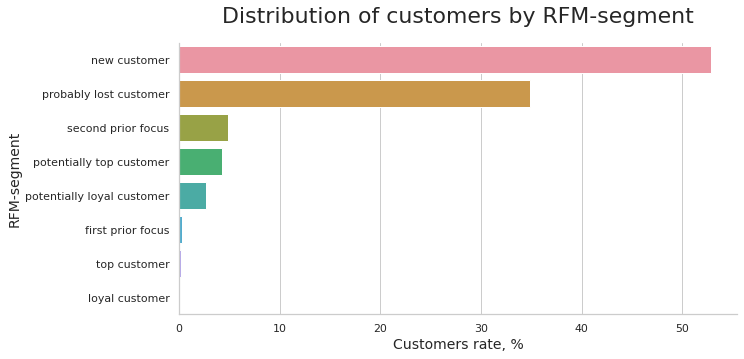

In [100]:
plt.figure(figsize=(10,5))

sns.barplot(data=customers_by_segment, y='description', x='customers_rate')            

plt.xlabel('Customers rate, %')
plt.ylabel('RFM-segment')
plt.title('Distribution of customers by RFM-segment')

sns.despine()
plt.show()

По распределению выше видно, что более 50% клиентов - новые, и более 30% - потенциально потерянные.  
Это может говорить о том что, мы продаем товары, которые люди покупают достаточно редко.

Приведем более понятную и читабельную визуализацию.  
Для этого посчитаем распределение клиентов по типам сегментов для каждой из RFM-метрик.

In [101]:
r_dist   = rfm.groupby('r_score', as_index=False).agg(r_customers=('Recency', 'count'))
f_dist   = rfm.groupby('f_score', as_index=False).agg(f_customers=('Recency', 'count'))
m_dist   = rfm.groupby('m_score', as_index=False).agg(m_customers=('Recency', 'count'))
rfm_dist = pd.concat([r_dist, f_dist, m_dist], axis=1)

Визуализируем данные.

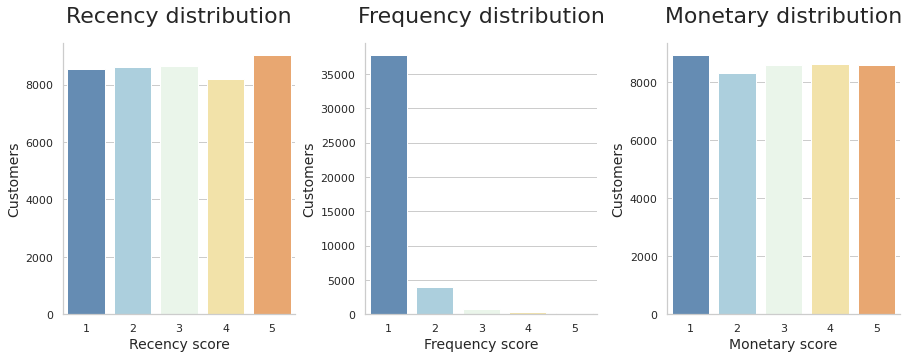

In [102]:
params    = ['Recency', 'Frequency', 'Monetary']
fig, axes = plt.subplots(nrows=1, ncols=metrics, figsize=(15, 5))

for i in range(metrics):
    ax     = axes[i]    
    column = i * 2
    
    sns.barplot(data=rfm_dist, x=rfm_dist.iloc[:, column], y=rfm_dist.iloc[:, column + 1], ax=ax)
        
    ax.set_title(f'{params[i]} distribution')           
    ax.set_xlabel(f'{params[i]} score') 
    ax.set_ylabel('Customers')       

sns.despine()
plt.subplots_adjust(wspace=0.3)            
plt.show()

Теперь распределение клиентов по группам для Recency и Monetary гораздо более равномерное  
Это соответсвует смыслу квантилей и гораздо лучше подходит для RFM-анализа.  
Распределение клиентов по метрике Frequency все еще сильно смещено влево.  
Однако с этим ничего нельзя сделать, так как большинство наших клиентов сделали только одну покупку.